<a href="https://colab.research.google.com/github/smayd01/ml_sirius/blob/main/Homework_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.1 SVD разложение

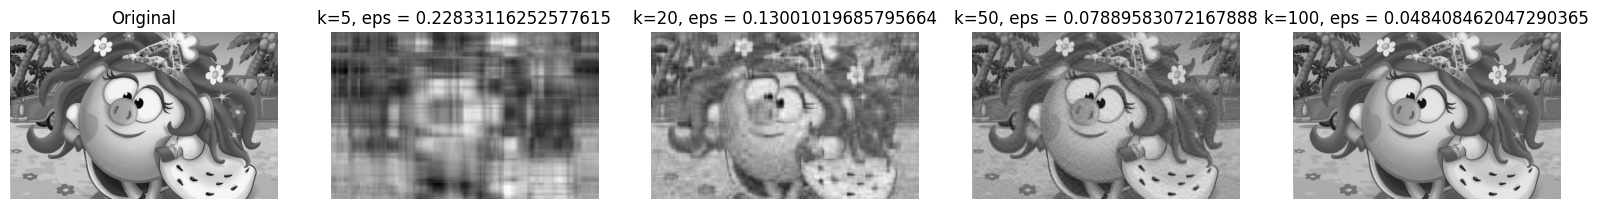

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def svd_compression(image_array, k):
    U, S, Vt = np.linalg.svd(image_array, full_matrices=False)
    compressed_image = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    return compressed_image

def plot_images(images, titles):
    num_images = len(images)
    plt.figure(figsize=(20, 12))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

image_path = '/content/1654633514_65-kartinkin-net-p-kartinki-nyushi-iz-smesharikov-70.jpg'
original_image = Image.open(image_path).convert('L')
original_array = np.array(original_image)

compression_levels = [5, 20, 50, 100]

compressed_images = []
titles = []
epsilon = []
norm_A = np.linalg.norm(original_array, 'fro')

for k in compression_levels:
    compressed_image = svd_compression(original_array, k)
    compressed_images.append(compressed_image)

    norm_diff = np.linalg.norm(original_array - compressed_image, 'fro')
    epsilon = norm_diff/norm_A

    titles.append(f'k={k}, eps = {epsilon}')

plot_images([original_array] + compressed_images, ['Original'] + titles)


# 1.2 Перемножение сжатой матрицы на вектор

In [ ]:
import numpy as np
import tensorflow as tf
import time

def create_matrix(n):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.sin(i + j) + 2
    return A

def matvec_original(A, x):
    return np.dot(A, x)

def matvec_compressed(U, S, Vt, x, k):
    return np.dot(np.dot(U, S), np.dot(Vt, x))

n = 2048
A = create_matrix(n)
x = np.random.rand(n)

start_time = time.time()
U, S, Vt = np.linalg.svd(A, full_matrices=False)
end_time = time.time()

k = 2  # Уровень сжатия
U = U[:, :k]
S = np.diag(S[:k])
Vt = Vt[:k, :]
start_time = time.time()
result_compressed = matvec_compressed(U, S, Vt, x, k)
end_time = time.time()
compressed_time = end_time - start_time

start_time = time.time()
result_original = matvec_original(A, x)
end_time = time.time()
original_time = end_time - start_time

print(f"Время работы matvec для сжатой матрицы (k={k}): {compressed_time} секунд")
print(f"Время работы matvec для оригинальной матрицы: {original_time} секунд")


Время работы matvec для сжатой матрицы (k=2): 0.00017380714416503906 секунд
Время работы matvec для оригинальной матрицы: 0.0012581348419189453 секунд


# 1.3 Epsilon-округление

In [ ]:
import numpy as np

def epsilon_rounding(A, epsilon):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    norm_A = np.linalg.norm(A, 'fro')
    norm_diff = epsilon + 1
    k = 0
    while norm_diff > epsilon and k < len(S):
        S_rounded = np.diag(S[:k+1])
        norm_diff = np.linalg.norm(S[:k+1] - np.diag(S_rounded))
        k += 1
    Ak = np.dot(U[:, :k], np.dot(S_rounded, Vt[:k, :]))
    return Ak

# Пример использования
A = np.random.rand(5, 5)
epsilon = 0.1

Ak = epsilon_rounding(A, epsilon)

print("Исходная матрица:")
print(A)
print("\nМатрица после epsilon-округления:")
print(Ak)


Исходная матрица:
[[0.84907747 0.63996765 0.5534492  0.76105985 0.71082782]
 [0.25134843 0.10617148 0.97154863 0.6023803  0.81567281]
 [0.19570388 0.38117206 0.16413798 0.41902257 0.68555392]
 [0.98371288 0.00113837 0.90816023 0.84125951 0.87015642]
 [0.77143008 0.46796545 0.23367324 0.31196678 0.9329311 ]]

Матрица после epsilon-округления:
[[0.73362049 0.3317973  0.67778089 0.68234893 0.88711817]
 [0.62560851 0.28294632 0.57799025 0.58188573 0.75650651]
 [0.39641726 0.17928913 0.36624392 0.36871229 0.47936086]
 [0.83410737 0.37724488 0.77061919 0.77581293 1.00863022]
 [0.59680321 0.26991843 0.55137747 0.55509358 0.72167418]]


# 2.1 SVD и R-SVD

In [ ]:
import numpy as np
from sklearn.utils.extmath import randomized_svd as rsvd

def create_matrix(n):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = 1 / (i + j + 1)
    return A

n = 2048
A = create_matrix(n)

def svd_rank(A, k):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    Ak = np.dot(U[:, :k] * S[:k], Vt[:k, :])
    return Ak

def rsvd_rank(A, k):
    U, S, Vt = rsvd(A , n_components=k, random_state=np.random.randint(1))
    Ak = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    return Ak

k_svd = 10
Ak_svd = svd_rank(A, k_svd)

k_rsvd = 15
Ak_rsvd = rsvd_rank(A, k_rsvd)

# Вычисление погрешностей
error_svd = np.linalg.norm(A - Ak_svd, 'fro') / np.linalg.norm(A, 'fro')
error_rsvd = np.linalg.norm(A - Ak_rsvd, 'fro') / np.linalg.norm(A, 'fro')

print(f"Уровень погрешности для SVD rank({k_svd}): {error_svd}")
print(f"Уровень погрешности для R-SVD rank({k_rsvd}): {error_rsvd}")


Уровень погрешности для SVD rank(10): 3.8128315309475075e-05
Уровень погрешности для R-SVD rank(15): 9.455431771734022e-08


# 2.2

Для неориентированного графа матрица смежности симметрична. Поэтому, если
B=A⋅AT−α⋅I, то B также будет симметричной матрицей.

In [ ]:
# Матрица инциндентности
A  = np.array([
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 1],
    [0, 1, 1, 0, 1, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 1]
])

B_without_alpha = np.dot(A, np.transpose(A))
print(f' B без alpha = \n {B_without_alpha}')

# Alpha должен занулить диагональные элементы
alpha = np.sum(A, axis = 1)
print(f' \n Вектор alpha = {alpha}')

B = np.dot(A, np.transpose(A)) - np.diag(alpha)
print(f' \n B= \n {B}')


 B без alpha = 
 [[2 1 1 0 0]
 [1 4 1 1 1]
 [1 1 3 1 0]
 [0 1 1 2 0]
 [0 1 0 0 1]]
 
 Вектор alpha = [2 4 3 2 1]
 
 B= 
 [[0 1 1 0 0]
 [1 0 1 1 1]
 [1 1 0 1 0]
 [0 1 1 0 0]
 [0 1 0 0 0]]


# 2.3 PageRank для московсокого метро

In [ ]:

LINES = {
    1: 'Сокольническая линия',
    2: 'Замоскворецкая линия',
    3: 'Арбатско-Покровская линия',
    4: 'Филевская линия',
    5: 'Кольцевая линия',
    6: 'Калужско-Рижская линия',
    7: 'Таганско-Краснопресненская линия',
    8: 'Калининско-Солнцевская линия',
    9: 'Серпуховско-Тимирязевская линия',
    10: 'Люблинско-Дмитровская линия',
    11: 'Каховская линия',
    12: 'Бутовская линия',
    13: 'Московский монорельс',
    14: 'Московское центральное кольцо',
    15: 'Большая кольцевая линия'
}


STATIONS = {
    1: {'line': 1, 'name': 'Бульвар Рокоссовского'},
    2: {'line': 1, 'name': 'Черкизовская'},
    3: {'line': 1, 'name': 'Преображенская площадь'},
    4: {'line': 1, 'name': 'Сокольники'},
    5: {'line': 1, 'name': 'Красносельская'},
    6: {'line': 1, 'name': 'Комсомольская'},
    7: {'line': 1, 'name': 'Красные Ворота'},
    8: {'line': 1, 'name': 'Чистые пруды'},
    9: {'line': 1, 'name': 'Лубянка'},
    10: {'line': 1, 'name': 'Охотный Ряд'},
    11: {'line': 1, 'name': 'Библиотека имени Ленина'},
    12: {'line': 1, 'name': 'Кропоткинская'},
    13: {'line': 1, 'name': 'Парк культуры'},
    14: {'line': 1, 'name': 'Фрунзенская'},
    15: {'line': 1, 'name': 'Спортивная'},
    16: {'line': 1, 'name': 'Воробьёвы горы'},
    17: {'line': 1, 'name': 'Университет'},
    18: {'line': 1, 'name': 'Проспект Вернадского'},
    19: {'line': 1, 'name': 'Юго-Западная'},
    20: {'line': 2, 'name': 'Речной вокзал'},
    21: {'line': 2, 'name': 'Водный стадион'},
    22: {'line': 2, 'name': 'Войковская'},
    23: {'line': 2, 'name': 'Сокол'},
    24: {'line': 2, 'name': 'Аэропорт'},
    25: {'line': 2, 'name': 'Динамо'},
    26: {'line': 2, 'name': 'Белорусская'},
    27: {'line': 2, 'name': 'Маяковская'},
    28: {'line': 2, 'name': 'Тверская'},
    29: {'line': 2, 'name': 'Театральная'},
    30: {'line': 2, 'name': 'Новокузнецкая'},
    31: {'line': 2, 'name': 'Павелецкая'},
    32: {'line': 2, 'name': 'Автозаводская'},
    33: {'line': 2, 'name': 'Коломенская'},
    34: {'line': 2, 'name': 'Каширская'},
    35: {'line': 2, 'name': 'Кантемировская'},
    36: {'line': 2, 'name': 'Царицыно'},
    37: {'line': 2, 'name': 'Орехово'},
    38: {'line': 2, 'name': 'Домодедовская'},
    39: {'line': 2, 'name': 'Красногвардейская'},
    40: {'line': 3, 'name': 'Щёлковская'},
    41: {'line': 3, 'name': 'Первомайская'},
    42: {'line': 3, 'name': 'Измайловская'},
    43: {'line': 3, 'name': 'Партизанская'},
    44: {'line': 3, 'name': 'Семёновская'},
    45: {'line': 3, 'name': 'Электрозаводская'},
    46: {'line': 3, 'name': 'Бауманская'},
    47: {'line': 3, 'name': 'Курская'},
    48: {'line': 3, 'name': 'Площадь Революции'},
    49: {'line': 3, 'name': 'Арбатская'},
    50: {'line': 3, 'name': 'Смоленская'},
    51: {'line': 3, 'name': 'Киевская'},
    52: {'line': 3, 'name': 'Парк Победы'},
    53: {'line': 3, 'name': 'Славянский бульвар'},
    54: {'line': 3, 'name': 'Кунцевская'},
    55: {'line': 3, 'name': 'Молодёжная'},
    56: {'line': 3, 'name': 'Крылатское'},
    57: {'line': 3, 'name': 'Строгино'},
    58: {'line': 4, 'name': 'Кунцевская'},
    59: {'line': 4, 'name': 'Пионерская'},
    60: {'line': 4, 'name': 'Филёвский парк'},
    61: {'line': 4, 'name': 'Багратионовская'},
    62: {'line': 4, 'name': 'Фили'},
    63: {'line': 4, 'name': 'Кутузовская'},
    64: {'line': 4, 'name': 'Студенческая'},
    65: {'line': 4, 'name': 'Киевская'},
    66: {'line': 4, 'name': 'Смоленская'},
    67: {'line': 4, 'name': 'Арбатская'},
    68: {'line': 4, 'name': 'Александровский сад'},
    69: {'line': 4, 'name': 'Выставочная'},
    70: {'line': 4, 'name': 'Международная'},
    71: {'line': 5, 'name': 'Парк культуры'},
    72: {'line': 5, 'name': 'Октябрьская'},
    73: {'line': 5, 'name': 'Добрынинская'},
    74: {'line': 5, 'name': 'Павелецкая'},
    75: {'line': 5, 'name': 'Таганская'},
    76: {'line': 5, 'name': 'Курская'},
    77: {'line': 5, 'name': 'Комсомольская'},
    78: {'line': 5, 'name': 'Проспект Мира'},
    79: {'line': 5, 'name': 'Новослободская'},
    80: {'line': 5, 'name': 'Белорусская'},
    81: {'line': 5, 'name': 'Краснопресненская'},
    82: {'line': 5, 'name': 'Киевская'},
    83: {'line': 6, 'name': 'Медведково'},
    84: {'line': 6, 'name': 'Бабушкинская'},
    85: {'line': 6, 'name': 'Свиблово'},
    86: {'line': 6, 'name': 'Ботанический сад'},
    87: {'line': 6, 'name': 'ВДНХ'},
    88: {'line': 6, 'name': 'Алексеевская'},
    89: {'line': 6, 'name': 'Рижская'},
    90: {'line': 6, 'name': 'Проспект Мира'},
    91: {'line': 6, 'name': 'Сухаревская'},
    92: {'line': 6, 'name': 'Тургеневская'},
    93: {'line': 6, 'name': 'Китай-город'},
    94: {'line': 6, 'name': 'Третьяковская'},
    95: {'line': 6, 'name': 'Октябрьская'},
    96: {'line': 6, 'name': 'Шаболовская'},
    97: {'line': 6, 'name': 'Ленинский проспект'},
    98: {'line': 6, 'name': 'Академическая'},
    99: {'line': 6, 'name': 'Профсоюзная'},
    100: {'line': 6, 'name': 'Новые Черёмушки'},
    101: {'line': 6, 'name': 'Калужская'},
    102: {'line': 6, 'name': 'Беляево'},
    103: {'line': 6, 'name': 'Коньково'},
    104: {'line': 6, 'name': 'Тёплый Стан'},
    105: {'line': 6, 'name': 'Ясенево'},
    106: {'line': 6, 'name': 'Новоясеневская'},
    107: {'line': 7, 'name': 'Планерная'},
    108: {'line': 7, 'name': 'Сходненская'},
    109: {'line': 7, 'name': 'Тушинская'},
    110: {'line': 7, 'name': 'Щукинская'},
    111: {'line': 7, 'name': 'Октябрьское Поле'},
    112: {'line': 7, 'name': 'Полежаевская'},
    113: {'line': 7, 'name': 'Беговая'},
    114: {'line': 7, 'name': 'Улица 1905 года'},
    115: {'line': 7, 'name': 'Баррикадная'},
    116: {'line': 7, 'name': 'Пушкинская'},
    117: {'line': 7, 'name': 'Кузнецкий Мост'},
    118: {'line': 7, 'name': 'Китай-город'},
    119: {'line': 7, 'name': 'Таганская'},
    120: {'line': 7, 'name': 'Пролетарская'},
    121: {'line': 7, 'name': 'Волгоградский проспект'},
    122: {'line': 7, 'name': 'Текстильщики'},
    123: {'line': 7, 'name': 'Кузьминки'},
    124: {'line': 7, 'name': 'Рязанский проспект'},
    125: {'line': 7, 'name': 'Выхино'},
    126: {'line': 8, 'name': 'Новогиреево'},
    127: {'line': 8, 'name': 'Перово'},
    128: {'line': 8, 'name': 'Шоссе Энтузиастов'},
    129: {'line': 8, 'name': 'Авиамоторная'},
    130: {'line': 8, 'name': 'Площадь Ильича'},
    131: {'line': 8, 'name': 'Марксистская'},
    132: {'line': 8, 'name': 'Третьяковская'},
    133: {'line': 9, 'name': 'Алтуфьево'},
    134: {'line': 9, 'name': 'Бибирево'},
    135: {'line': 9, 'name': 'Отрадное'},
    136: {'line': 9, 'name': 'Владыкино'},
    137: {'line': 9, 'name': 'Петровско-Разумовская'},
    138: {'line': 9, 'name': 'Тимирязевская'},
    139: {'line': 9, 'name': 'Дмитровская'},
    140: {'line': 9, 'name': 'Савёловская'},
    141: {'line': 9, 'name': 'Менделеевская'},
    142: {'line': 9, 'name': 'Цветной бульвар'},
    143: {'line': 9, 'name': 'Чеховская'},
    144: {'line': 9, 'name': 'Боровицкая'},
    145: {'line': 9, 'name': 'Полянка'},
    146: {'line': 9, 'name': 'Серпуховская'},
    147: {'line': 9, 'name': 'Тульская'},
    148: {'line': 9, 'name': 'Нагатинская'},
    149: {'line': 9, 'name': 'Нагорная'},
    150: {'line': 9, 'name': 'Нахимовский проспект'},
    151: {'line': 9, 'name': 'Севастопольская'},
    152: {'line': 9, 'name': 'Чертановская'},
    153: {'line': 9, 'name': 'Южная'},
    154: {'line': 9, 'name': 'Пражская'},
    155: {'line': 9, 'name': 'Улица Академика Янгеля'},
    156: {'line': 9, 'name': 'Аннино'},
    157: {'line': 9, 'name': 'Бульвар Дмитрия Донского'},
    158: {'line': 10, 'name': 'Трубная'},
    159: {'line': 10, 'name': 'Сретенский бульвар'},
    160: {'line': 10, 'name': 'Чкаловская'},
    161: {'line': 10, 'name': 'Римская'},
    162: {'line': 10, 'name': 'Крестьянская Застава'},
    163: {'line': 10, 'name': 'Дубровка'},
    164: {'line': 10, 'name': 'Кожуховская'},
    165: {'line': 10, 'name': 'Печатники'},
    166: {'line': 10, 'name': 'Волжская'},
    167: {'line': 10, 'name': 'Люблино'},
    168: {'line': 10, 'name': 'Братиславская'},
    169: {'line': 10, 'name': 'Марьино'},
    170: {'line': 11, 'name': 'Каширская'},
    171: {'line': 11, 'name': 'Варшавская'},
    172: {'line': 11, 'name': 'Каховская'},
    173: {'line': 12, 'name': 'Улица Старокачаловская'},
    174: {'line': 12, 'name': 'Улица Скобелевская'},
    175: {'line': 12, 'name': 'Бульвар Адмирала Ушакова'},
    176: {'line': 12, 'name': 'Улица Горчакова'},
    177: {'line': 12, 'name': 'Бунинская аллея'},
    178: {'line': 3, 'name': 'Мякинино'},
    179: {'line': 3, 'name': 'Волоколамская'},
    180: {'line': 3, 'name': 'Митино'},
    181: {'line': 10, 'name': 'Марьина Роща'},
    182: {'line': 10, 'name': 'Достоевская'},
    183: {'line': 10, 'name': 'Борисово'},
    184: {'line': 10, 'name': 'Шипиловская'},
    185: {'line': 10, 'name': 'Зябликово'},
    186: {'line': 8, 'name': 'Новокосино'},
    187: {'line': 2, 'name': 'Алма-Атинская'},
    188: {'line': 3, 'name': 'Пятницкое шоссе'},
    189: {'line': 7, 'name': 'Лермонтовский проспект'},
    190: {'line': 7, 'name': 'Жулебино'},
    191: {'line': 12, 'name': 'Битцевский парк'},
    192: {'line': 12, 'name': 'Лесопарковая'},
    193: {'line': 8, 'name': 'Шелепиха'},
    194: {'line': 8, 'name': 'Парк Победы'},
    195: {'line': 7, 'name': 'Спартак'},
    196: {'line': 1, 'name': 'Тропарёво'},
    197: {'line': 7, 'name': 'Котельники'},
    198: {'line': 2, 'name': 'Технопарк'},
    199: {'line': 1, 'name': 'Румянцево'},
    200: {'line': 1, 'name': 'Саларьево'},
    201: {'line': 14, 'name': 'Ботанический сад'},
    202: {'line': 14, 'name': 'Владыкино'},
    203: {'line': 14, 'name': 'Окружная'},
    204: {'line': 14, 'name': 'Лихоборы'},
    205: {'line': 14, 'name': 'Коптево'},
    206: {'line': 14, 'name': 'Балтийская'},
    207: {'line': 14, 'name': 'Стрешнево'},
    208: {'line': 14, 'name': 'Панфиловская'},
    209: {'line': 14, 'name': 'Зорге'},
    210: {'line': 14, 'name': 'Хорошёво'},
    211: {'line': 14, 'name': 'Шелепиха'},
    212: {'line': 14, 'name': 'Деловой центр'},
    213: {'line': 14, 'name': 'Кутузовская'},
    214: {'line': 14, 'name': 'Лужники'},
    215: {'line': 14, 'name': 'Площадь Гагарина'},
    216: {'line': 14, 'name': 'Крымская'},
    217: {'line': 14, 'name': 'Верхние Котлы'},
    218: {'line': 14, 'name': 'ЗИЛ'},
    219: {'line': 14, 'name': 'Автозаводская'},
    220: {'line': 14, 'name': 'Дубровка'},
    221: {'line': 14, 'name': 'Угрешская'},
    222: {'line': 14, 'name': 'Новохохловская'},
    223: {'line': 14, 'name': 'Нижегородская'},
    224: {'line': 14, 'name': 'Андроновка'},
    225: {'line': 14, 'name': 'Шоссе Энтузиастов'},
    226: {'line': 14, 'name': 'Соколиная гора'},
    227: {'line': 14, 'name': 'Измайлово'},
    228: {'line': 14, 'name': 'Локомотив'},
    229: {'line': 14, 'name': 'Бульвар Рокоссовского'},
    230: {'line': 14, 'name': 'Белокаменная'},
    231: {'line': 14, 'name': 'Ростокино'},
    232: {'line': 10, 'name': 'Бутырская'},
    233: {'line': 10, 'name': 'Фонвизинская'},
    234: {'line': 10, 'name': 'Петровско-Разумовская'},
    235: {'line': 8, 'name': 'Минская'},
    236: {'line': 8, 'name': 'Ломоносовский проспект'},
    237: {'line': 8, 'name': 'Раменки'},
    238: {'line': 15, 'name': 'Деловой центр'},
    239: {'line': 15, 'name': 'Шелепиха'},
    240: {'line': 15, 'name': 'Хорошёвская'},
    241: {'line': 15, 'name': 'ЦСКА'},
    242: {'line': 15, 'name': 'Петровский парк'},
    243: {'line': 8, 'name': 'Хорошёвская'},
    244: {'line': 8, 'name': 'ЦСКА'},
    245: {'line': 8, 'name': 'Петровский парк'},
    246: {'line': 2, 'name': 'Ховрино'},
    247: {'line': 10, 'name': 'Окружная'},
    248: {'line': 10, 'name': 'Верхние Лихоборы'},
    249: {'line': 10, 'name': 'Селигерская'}
}


LINKS = [
    # List of connections between stations
    # (source, target, time)
    (1, 2, 190),
    (1, 229, 541),
    (2, 3, 145),
    (2, 228, 300),
    (3, 4, 200),
    (4, 5, 135),
    (5, 6, 115),
    (6, 7, 110),
    (6, 77, 360),
    (7, 8, 100),
    (8, 9, 115),
    (8, 92, 180),
    (8, 159, 180),
    (9, 10, 100),
    (9, 117, 180),
    (10, 11, 105),
    (10, 29, 240),
    (11, 12, 115),
    (11, 49, 300),
    (11, 68, 180),
    (11, 144, 360),
    (12, 13, 130),
    (13, 14, 150),
    (13, 71, 300),
    (14, 15, 95),
    (15, 16, 185),
    (15, 214, 360),
    (16, 17, 225),
    (17, 18, 180),
    (18, 19, 170),
    (19, 196, 170),
    (20, 21, 155),
    (20, 246, 240),
    (21, 22, 180),
    (22, 23, 170),
    (22, 206, 780),
    (23, 24, 130),
    (24, 25, 170),
    (25, 26, 180),
    (25, 242, 360),
    (25, 245, 360),
    (26, 27, 110),
    (26, 80, 180),
    (27, 28, 100),
    (28, 29, 100),
    (28, 116, 180),
    (28, 143, 240),
    (29, 30, 160),
    (29, 48, 300),
    (30, 31, 140),
    (30, 94, 180),
    (30, 132, 180),
    (31, 32, 180),
    (31, 74, 240),
    (32, 198, 140),
    (32, 219, 600),
    (33, 34, 200),
    (34, 35, 205),
    (34, 170, 180),
    (35, 36, 145),
    (36, 37, 165),
    (37, 38, 145),
    (38, 39, 150),
    (39, 185, 150),
    (39, 187, 250),
    (40, 41, 135),
    (41, 42, 170),
    (42, 43, 190),
    (43, 44, 165),
    (43, 227, 540),
    (44, 45, 110),
    (45, 46, 145),
    (46, 47, 175),
    (47, 48, 185),
    (47, 76, 240),
    (47, 160, 180),
    (48, 49, 125),
    (49, 50, 140),
    (49, 68, 180),
    (49, 144, 180),
    (50, 51, 105),
    (51, 52, 270),
    (51, 65, 240),
    (51, 82, 180),
    (52, 53, 260),
    (52, 194, 120),
    (53, 54, 170),
    (54, 55, 180),
    (54, 58, 180),
    (55, 56, 195),
    (56, 57, 420),
    (57, 178, 205),
    (58, 59, 130),
    (59, 60, 115),
    (60, 61, 115),
    (61, 62, 140),
    (62, 63, 145),
    (63, 64, 120),
    (63, 213, 360),
    (64, 65, 140),
    (65, 66, 130),
    (65, 69, 395),
    (65, 82, 360),
    (66, 67, 115),
    (67, 68, 65),
    (69, 70, 120),
    (69, 238, 180),
    (70, 212, 360),
    (71, 72, 120),
    (72, 73, 105),
    (72, 95, 180),
    (73, 74, 115),
    (73, 146, 180),
    (74, 75, 135),
    (75, 76, 170),
    (75, 119, 180),
    (75, 131, 180),
    (76, 77, 175),
    (76, 160, 360),
    (77, 78, 160),
    (78, 79, 160),
    (78, 90, 180),
    (79, 80, 135),
    (79, 141, 180),
    (80, 81, 165),
    (81, 82, 160),
    (81, 115, 180),
    (82, 71, 175),
    (83, 84, 160),
    (84, 85, 140),
    (85, 86, 135),
    (86, 87, 210),
    (86, 201, 240),
    (87, 88, 135),
    (88, 89, 140),
    (89, 90, 130),
    (90, 91, 120),
    (91, 92, 100),
    (92, 93, 125),
    (92, 159, 180),
    (93, 94, 170),
    (93, 118, 120),
    (94, 95, 155),
    (94, 132, 120),
    (95, 96, 130),
    (96, 97, 190),
    (97, 98, 185),
    (97, 215, 180),
    (98, 99, 120),
    (99, 100, 100),
    (100, 101, 140),
    (101, 102, 170),
    (102, 103, 115),
    (103, 104, 150),
    (104, 105, 170),
    (105, 106, 140),
    (106, 191, 120),
    (107, 108, 110),
    (108, 109, 175),
    (109, 195, 100),
    (110, 111, 185),
    (111, 112, 200),
    (111, 208, 720),
    (112, 113, 150),
    (112, 210, 720),
    (112, 240, 180),
    (112, 243, 180),
    (113, 114, 130),
    (114, 115, 125),
    (115, 116, 165),
    (116, 117, 120),
    (116, 143, 240),
    (117, 118, 90),
    (118, 119, 170),
    (119, 120, 145),
    (119, 131, 240),
    (120, 121, 150),
    (120, 162, 300),
    (121, 122, 245),
    (122, 123, 185),
    (123, 124, 185),
    (124, 125, 170),
    (125, 189, 240),
    (126, 127, 150),
    (127, 128, 195),
    (128, 129, 150),
    (128, 225, 600),
    (129, 130, 180),
    (130, 131, 175),
    (130, 161, 180),
    (131, 132, 160),
    (133, 134, 150),
    (134, 135, 195),
    (135, 136, 165),
    (136, 137, 145),
    (136, 202, 420),
    (137, 138, 200),
    (138, 139, 110),
    (139, 140, 120),
    (140, 141, 120),
    (141, 142, 160),
    (142, 143, 110),
    (142, 158, 180),
    (143, 144, 150),
    (144, 145, 145),
    (145, 146, 120),
    (146, 147, 205),
    (147, 148, 225),
    (148, 149, 120),
    (148, 217, 720),
    (149, 150, 100),
    (150, 151, 110),
    (151, 152, 125),
    (151, 172, 240),
    (152, 153, 190),
    (153, 154, 110),
    (154, 155, 150),
    (155, 156, 115),
    (156, 157, 160),
    (157, 173, 120),
    (158, 159, 160),
    (159, 160, 160),
    (160, 161, 175),
    (161, 162, 165),
    (162, 163, 145),
    (163, 164, 130),
    (163, 220, 780),
    (164, 165, 240),
    (165, 166, 160),
    (166, 167, 170),
    (167, 168, 185),
    (168, 169, 140),
    (169, 183, 150),
    (170, 171, 175),
    (171, 172, 125),
    (173, 174, 295),
    (174, 175, 80),
    (175, 176, 105),
    (176, 177, 115),
    (178, 179, 180),
    (179, 180, 170),
    (180, 188, 120),
    (181, 182, 150),
    (181, 232, 205),
    (182, 158, 150),
    (183, 184, 130),
    (184, 185, 110),
    (186, 126, 200),
    (189, 190, 180),
    (190, 197, 120),
    (191, 192, 180),
    (192, 173, 180),
    (193, 194, 310),
    (193, 211, 180),
    (193, 239, 27),
    (194, 235, 180),
    (195, 110, 185),
    (196, 199, 180),
    (198, 33, 140),
    (199, 200, 145),
    (201, 202, 290),
    (202, 203, 170),
    (203, 204, 180),
    (204, 205, 210),
    (205, 206, 265),
    (206, 207, 180),
    (207, 208, 180),
    (208, 209, 160),
    (209, 210, 160),
    (210, 211, 225),
    (210, 240, 720),
    (210, 243, 720),
    (211, 212, 150),
    (211, 239, 180),
    (212, 213, 150),
    (213, 214, 220),
    (214, 215, 240),
    (215, 216, 230),
    (216, 217, 140),
    (217, 218, 200),
    (218, 219, 150),
    (219, 220, 150),
    (220, 221, 155),
    (221, 222, 170),
    (222, 223, 165),
    (223, 224, 210),
    (224, 225, 160),
    (225, 226, 170),
    (226, 227, 190),
    (227, 228, 175),
    (228, 229, 180),
    (229, 230, 195),
    (230, 231, 210),
    (231, 201, 180),
    (232, 233, 150),
    (233, 234, 180),
    (234, 137, 60),
    (234, 247, 120),
    (235, 236, 240),
    (236, 237, 120),
    (238, 239, 180),
    (239, 240, 230),
    (240, 241, 120),
    (241, 242, 140),
    (241, 244, 29),
    (242, 245, 27),
    (243, 193, 230),
    (243, 240, 29),
    (243, 244, 120),
    (244, 245, 140),
    (247, 203, 480),
    (247, 248, 120),
    (248, 249, 180)
]

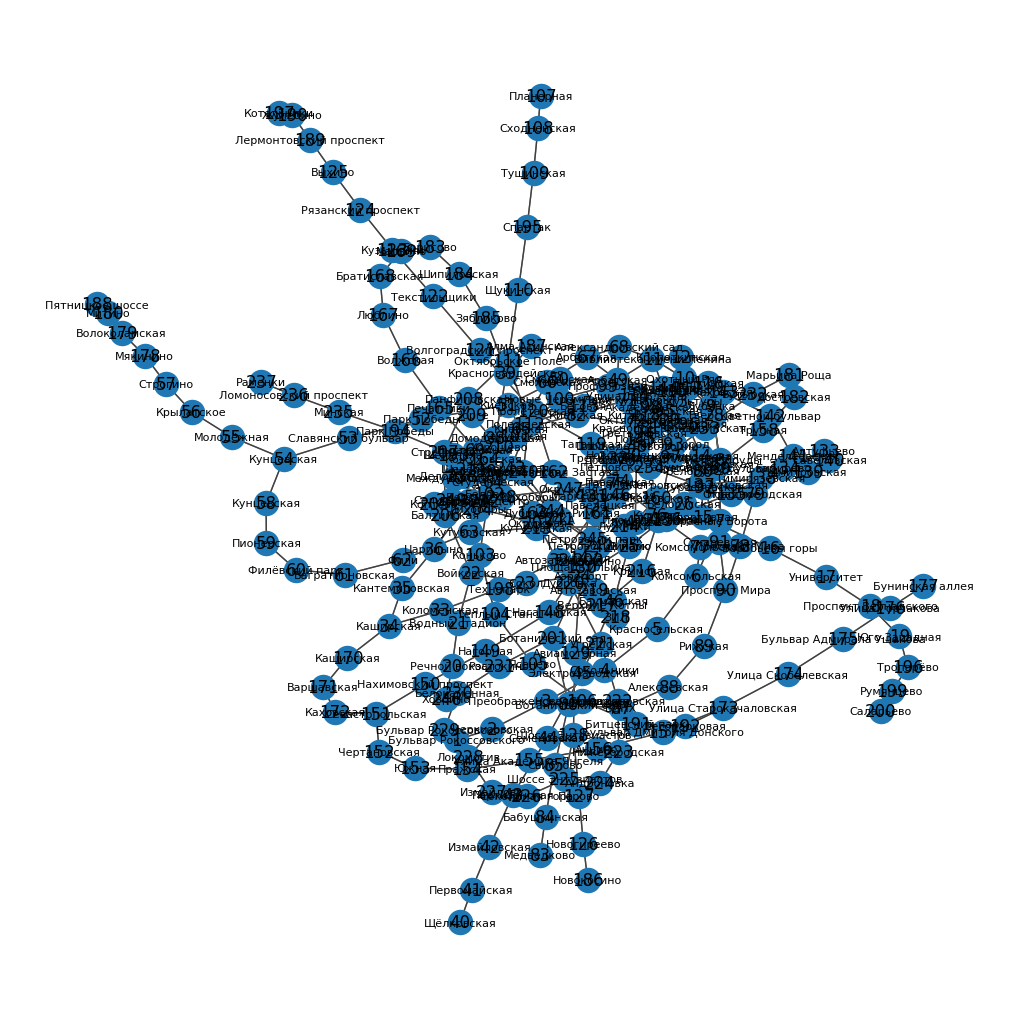

Станция: Бульвар Рокоссовского, PageRank: 0.0033
Станция: Черкизовская, PageRank: 0.0048
Станция: Преображенская площадь, PageRank: 0.0034
Станция: Сокольники, PageRank: 0.0035
Станция: Красносельская, PageRank: 0.0033
Станция: Комсомольская, PageRank: 0.0044
Станция: Красные Ворота, PageRank: 0.0029
Станция: Чистые пруды, PageRank: 0.0051
Станция: Лубянка, PageRank: 0.0038
Станция: Охотный Ряд, PageRank: 0.0037
Станция: Библиотека имени Ленина, PageRank: 0.0058
Станция: Кропоткинская, PageRank: 0.0028
Станция: Парк культуры, PageRank: 0.0043
Станция: Фрунзенская, PageRank: 0.0031
Станция: Спортивная, PageRank: 0.0047
Станция: Воробьёвы горы, PageRank: 0.0035
Станция: Университет, PageRank: 0.0038
Станция: Проспект Вернадского, PageRank: 0.0040
Станция: Юго-Западная, PageRank: 0.0041
Станция: Речной вокзал, PageRank: 0.0043
Станция: Водный стадион, PageRank: 0.0039
Станция: Войковская, PageRank: 0.0051
Станция: Сокол, PageRank: 0.0034
Станция: Аэропорт, PageRank: 0.0032
Станция: Динамо

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

metro_graph = nx.Graph()

for station_id, station_info in STATIONS.items():
    station_name = station_info['name']
    station_line = LINES[station_info['line']]
    metro_graph.add_node(station_id, name=station_name, line=station_line)

for link in LINKS:
    source, target, time = link
    metro_graph.add_edge(source, target, time=time)

for station_id, station_info in STATIONS.items():
    station_name = station_info['name']
    transfers = [transfer for transfer in STATIONS.values() if transfer['name'] == station_name and transfer['line'] != station_info['line']]
    for transfer in transfers:
        transfer_station_id = list(STATIONS.keys())[list(STATIONS.values()).index(transfer)]
        metro_graph.add_edge(station_id, transfer_station_id)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(metro_graph)
nx.draw(metro_graph, pos, with_labels=True)
nx.draw_networkx_nodes(metro_graph, pos, node_size=0.001)
nx.draw_networkx_labels(metro_graph, pos, labels=nx.get_node_attributes(metro_graph, 'name'), font_size=8)
nx.draw_networkx_edges(metro_graph, pos, edge_color='gray', width=1.0, alpha=0.5)
plt.show()

pagerank = nx.pagerank(metro_graph)

for station_id, pr in pagerank.items():
    station_name = STATIONS[station_id]['name']
    print(f"Станция: {station_name}, PageRank: {pr:.4f}")

max_pagerank_station_id = max(pagerank, key=pagerank.get)
max_pagerank_station_name = STATIONS[max_pagerank_station_id]['name']
max_pagerank_value = pagerank[max_pagerank_station_id]

print(f"\n Станция с максимальным значением PageRank: {max_pagerank_station_name}")
print(f"Значение PageRank: {max_pagerank_value:.4f}")


# 3.1 Выборка методом Метрополиса-Гастинга

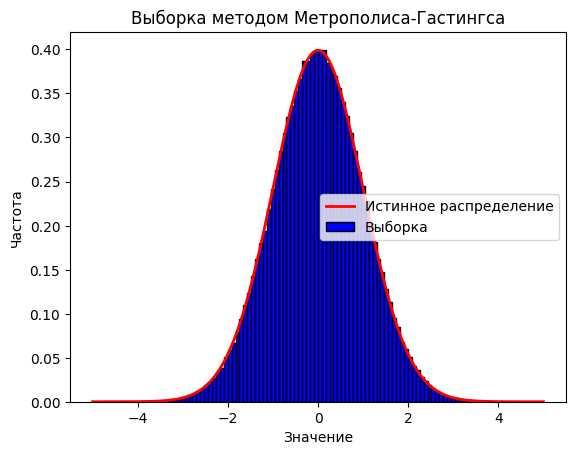

Среднее выборки: 0.002143718414826094


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def function(x):
    return np.exp(-0.5 * x**2)

def metropolis(n_samples):
    samples = []
    x_current = np.random.normal()
    for _ in range(n_samples):
        x_proposed = x_current + np.random.normal(0, 1)
        alpha = function(x_proposed) / function(x_current)
        if np.random.uniform(0, 1) < alpha:
            samples.append(x_proposed)
            x_current = x_proposed
        else:
            samples.append(x_current)
    return samples

n_samples = 1000000
samples = metropolis(n_samples)

plt.hist(samples, bins=100, density=True, color='blue', edgecolor='black')

x_range = np.linspace(-5, 5, 1000)
integral = np.trapz(function(x_range), x_range)
plt.plot(x_range, function(x_range)/integral, color='red', linewidth=2)

plt.title('Выборка методом Метрополиса-Гастингса')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.legend(['Истинное распределение', 'Выборка'])
plt.show()

print("Среднее выборки:", np.mean(samples))


# 3.2

<ipython-input-12-a61ac6591d59>:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000)
/usr/local/lib/python3.10/dist-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


              ST       ST_conf
x1  3.577771e-08  3.143728e-09
x2  3.580419e-08  3.113308e-09
x3  9.960253e-01  5.584344e-02
              S1   S1_conf
x1  4.843813e-07  0.000018
x2 -8.201907e-07  0.000017
x3  9.961152e-01  0.075488
                S2   S2_conf
(x1, x2) -0.000001  0.000023
(x1, x3) -0.000001  0.000032
(x2, x3)  0.000001  0.000031
Total sensitivity indices:
[ 4.84381276e-07 -8.20190685e-07  9.96115213e-01]
Interaction indices:
[[            nan -1.01468676e-06 -1.24583039e-06]
 [            nan             nan  1.36343355e-06]
 [            nan             nan             nan]]


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

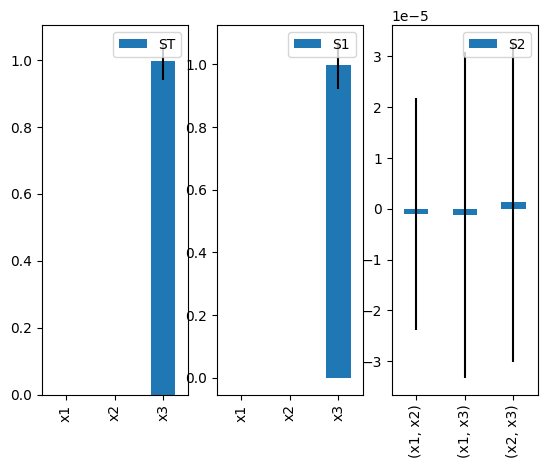

In [ ]:
#!pip install SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np

def function(x):
    x1, x2, x3 = x
    return 1e-4 * np.sin(x1 + x2) + x3

problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[0, np.pi], [0, np.pi], [0, 1]]
}

param_values = saltelli.sample(problem, 1000)
Y = np.array([function(x) for x in param_values])
sensitivity_results = sobol.analyze(problem, Y, print_to_console=True)

print("Total sensitivity indices:")
print(sensitivity_results['S1'])
print("Interaction indices:")
print(sensitivity_results['S2'])

sensitivity_results.plot()
